In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 繪圖的時間刻度
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# 評估成果
from sklearn import metrics

# Data preprocessing

## training data

In [2]:
train_data = pd.read_csv('train.csv', parse_dates=['Date'])
train_data.drop(columns=['Volume'], inplace=True)
train_data['Up or Down'] = 0
train_data.head()

,Date,Open Price,Close Price,High Price,Low Price,Up or Down
0,2009-01-02,902.99,931.80,934.73,899.35,0
1,2009-01-05,929.17,927.45,936.63,919.53,0
2,2009-01-06,931.17,934.70,943.85,927.28,0
3,2009-01-07,927.45,906.65,927.45,902.37,0
4,2009-01-08,905.73,909.73,910.00,896.81,0


In [3]:
for index, row in train_data.iterrows():
    if index < len(train_data.index)-1:
        train_data.loc[index, 'Up or Down'] = 1 if train_data.loc[index+1, 'Close Price']>row['Close Price'] else 0
train_data.head()

,Date,Open Price,Close Price,High Price,Low Price,Up or Down
0,2009-01-02,902.99,931.80,934.73,899.35,0
1,2009-01-05,929.17,927.45,936.63,919.53,1
2,2009-01-06,931.17,934.70,943.85,927.28,0
3,2009-01-07,927.45,906.65,927.45,902.37,1
4,2009-01-08,905.73,909.73,910.00,896.81,0


與隔天的收盤價比較，漲為 1 跌為 0，最後一天的沒有對象所以為預設

In [4]:
train_X = train_data[['Open Price', 'Close Price']]
train_Y = train_data['Up or Down']

* 高低點對預測隔天的漲跌效果有限
* 因為使用的特徵都是價格，所以不須正規化

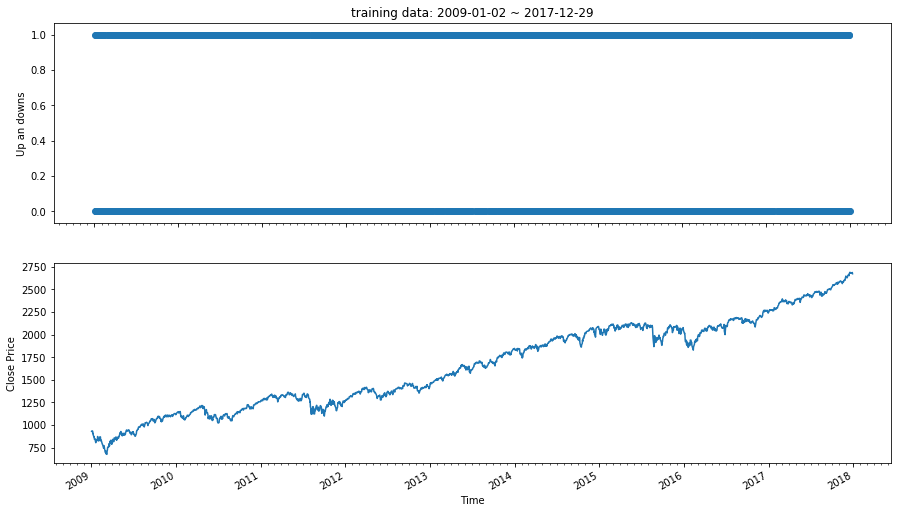

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 9))

fig.autofmt_xdate()
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.set(title='training data: 2009-01-02 ~ 2017-12-29', ylabel='Up an downs')
ax1.scatter(train_data['Date'], train_data['Up or Down'])

ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_minor_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.set(xlabel='Time', ylabel='Close Price')
ax2.plot(train_data['Date'], train_data['Close Price'])
plt.show()

In [6]:
train_data['Up or Down'].value_counts()

1    1236
0    1028
Name: Up or Down, dtype: int64

漲跌數量相對平均，但整體價格趨勢是持續上揚

## test data

In [7]:
test_data = pd.read_csv('test.csv', parse_dates=['Date'])
test_data.drop(columns=['Volume'], inplace=True)
test_data['Up or Down'] = 0
test_data.head()

,Date,Open Price,Close Price,High Price,Low Price,Up or Down
0,2018-01-02,2683.73,2695.81,2695.89,2682.36,0
1,2018-01-03,2697.85,2713.06,2714.37,2697.77,0
2,2018-01-04,2719.31,2723.99,2729.29,2719.07,0
3,2018-01-05,2731.33,2743.15,2743.45,2727.92,0
4,2018-01-08,2742.67,2747.71,2748.51,2737.60,0


In [8]:
for index, row in test_data.iterrows():
    if index < len(test_data.index)-1:
        test_data.loc[index, 'Up or Down'] = 1 if test_data.loc[index+1, 'Close Price']>row['Close Price'] else 0
test_data.head()

,Date,Open Price,Close Price,High Price,Low Price,Up or Down
0,2018-01-02,2683.73,2695.81,2695.89,2682.36,1
1,2018-01-03,2697.85,2713.06,2714.37,2697.77,1
2,2018-01-04,2719.31,2723.99,2729.29,2719.07,1
3,2018-01-05,2731.33,2743.15,2743.45,2727.92,1
4,2018-01-08,2742.67,2747.71,2748.51,2737.60,1


In [9]:
test_X = test_data[['Open Price', 'Close Price']]
test_Y = test_data['Up or Down']

高低點對預測下一天的漲跌效果有限

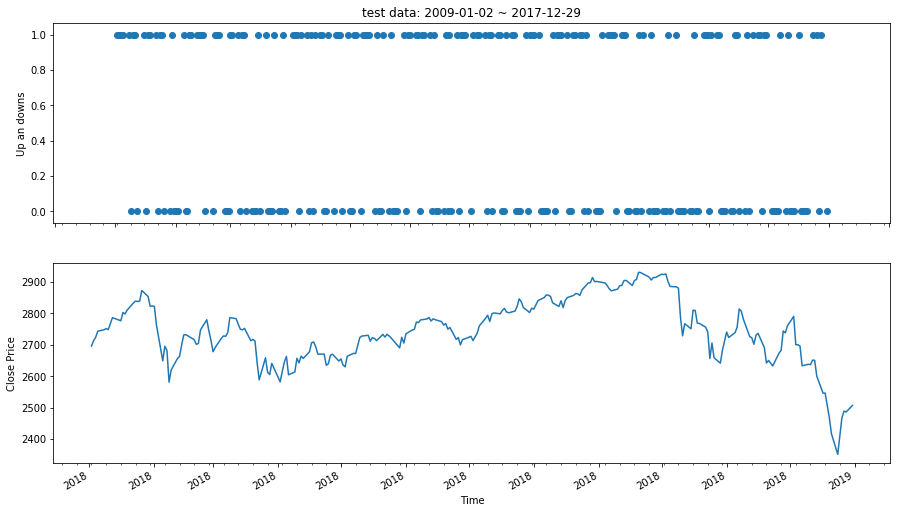

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 9))

fig.autofmt_xdate()
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax1.set(title='test data: 2009-01-02 ~ 2017-12-29', ylabel='Up an downs')
ax1.scatter(test_data['Date'], test_data['Up or Down'])

ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.set(xlabel='Time', ylabel='Close Price')
ax2.plot(test_data['Date'], test_data['Close Price'])
plt.show()

In [11]:
test_data['Up or Down'].value_counts()

1    131
0    121
Name: Up or Down, dtype: int64

測試資料的趨勢變動較大

# Logistic regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_regression

In [13]:
logistic_model = LogisticRegression(solver='liblinear', multi_class='auto')
logistic_model.fit(train_X, train_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

liblinear 適合小型資料

In [14]:
train_predict = logistic_model.predict(train_X)
print('training acuuracy: ' + str(metrics.accuracy_score(train_Y, train_predict)))
print('training AUC: ' + str(metrics.roc_auc_score(train_Y, train_predict)))
print('training p-values: ' + str(f_regression(train_X, train_Y)[1]))

training acuuracy: 0.5450530035335689
training AUC: 0.5023012604989108
training p-values: [0.28711986 0.2586878 ]


* 訓練資料正確率 54.50 %，AUC > 0.5
* p-value 皆無法 < 0.05，表示特徵上是沒有顯著差異的，畢竟股票價格起伏不會太大，同時訓練範圍較廣

In [15]:
test_predict = logistic_model.predict(test_X)
print('test acuuracy: ' + str(metrics.accuracy_score(test_Y, test_predict)))
print('test AUC: ' + str(metrics.roc_auc_score(test_Y, test_predict)))
print('test p-values: ' + str(f_regression(test_X, test_Y)[1]))

test acuuracy: 0.5079365079365079
test AUC: 0.4954892435808466
test p-values: [0.10110169 0.11322872]


* 測試資料正確率 50.79 %，AUC > 0.5
* 由於樣本相對較少，有較好的 p-value，不過依然是不夠顯著

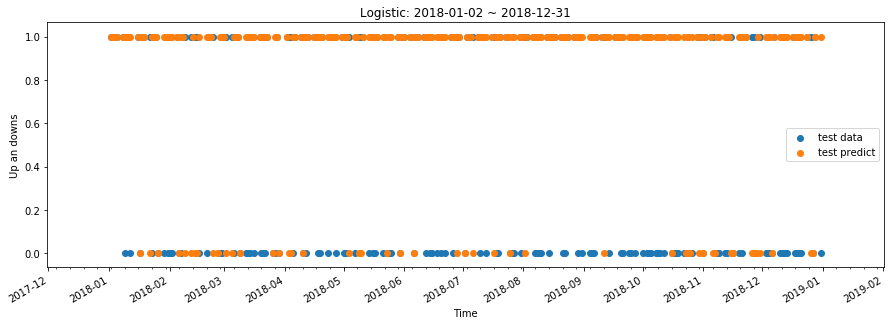

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
# 調整 x 軸
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.set(title='Logistic: 2018-01-02 ~ 2018-12-31', xlabel='Time', ylabel='Up an downs')
ax.scatter(test_data['Date'], test_data['Up or Down'], label='test data')
ax.scatter(test_data['Date'], test_predict, label='test predict')
ax.legend()
plt.show()

預測結果集中在同一側

# Support vector machine

In [17]:
from sklearn.svm import SVC

In [18]:
svc = SVC(gamma='auto', kernel='linear')
svc.fit(train_X, train_Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

股票走勢比較偏線性，此時接近迴歸的作法

In [19]:
train_predict = svc.predict(train_X)
print('training acuuracy: ' + str(metrics.accuracy_score(train_Y, train_predict)))
print('training AUC: ' + str(metrics.roc_auc_score(train_Y, train_predict)))

training acuuracy: 0.5477031802120141
training AUC: 0.5054651001725158


訓練資料正確率 54.77 %，AUC > 0.5

In [20]:
test_predict = svc.predict(test_X)
print('test acuuracy: ' + str(metrics.accuracy_score(test_Y, test_predict)))
print('test AUC: ' + str(metrics.roc_auc_score(test_Y, test_predict)))

test acuuracy: 0.44047619047619047
test AUC: 0.43312724749227177


測試資料正確率 44.05 %，AUC < 0.5

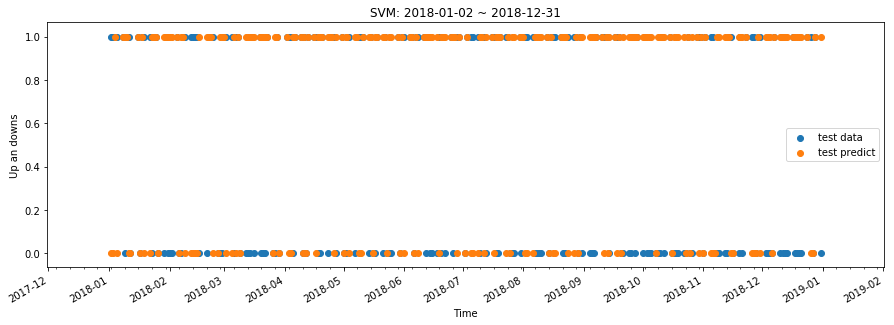

In [21]:
fig, ax = plt.subplots(figsize=(15, 5))

fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.set(title='SVM: 2018-01-02 ~ 2018-12-31', xlabel='Time', ylabel='Up an downs')
ax.scatter(test_data['Date'], test_data['Up or Down'], label='test data')
ax.scatter(test_data['Date'], test_predict, label='test predict')
ax.legend()
plt.show()

預測結果集中在同一側

# Neural network

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

Using TensorFlow backend.


In [23]:
model = Sequential()
# hidden layer
# model.add(Dense(input_dim=2, units=4, activation='relu'))
# model.add(Dense(input_dim=2, units=2, activation='relu'))
# output layer
model.add(Dense(input_dim=2, units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_Y, epochs=10, batch_size=32)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2264/2264 [==============================] - 0s 84us/step - loss: 7.2389 - acc: 0.5459
Epoch 2/10
2264/2264 [==============================] - 0s 25us/step - loss: 7.2389 - acc: 0.5459
Epoch 3/10
2264/2264 [==============================] - 0s 22us/step - loss: 7.2389 - acc: 0.5459
Epoch 4/10
2264/2264 [==============================] - 0s 22us/step - loss: 7.2389 - acc: 0.5459
Epoch 5/10
2264/2264 [==============================] - 0s 21us/step - loss: 7.2389 - acc: 0.5459
Epoch 6/10
2264/2264 [==============================] - 0s 21us/step - loss: 7.2389 - acc: 0.5459
Epoch 7/10
2264/2264 [==============================] - 0s 22us/step - loss: 7.2389 - acc: 0.5459
Epoch 8/10
2264/2264 [==============================] - 0s 24us/step - loss: 7.2389 - acc: 0.5459
Epoch 9/10
2264/2264 [==============================] - 0s 25us/step - loss: 7.2389 - acc: 0.545

* 特徵只有兩個，隱藏層效益不大
* 要預測的只有二種可能，所以選用 sigmoid 與 binary_crossentropy
* adam 有較低的訓練成本

In [24]:
print('training acuuracy: ' + str(model.evaluate(train_X, train_Y, batch_size=32)[1]))

2264/2264 [==============================] - 0s 24us/step
training acuuracy: 0.5459363958650258


In [25]:
print('test acuuracy: ' + str(model.evaluate(test_X, test_Y, batch_size=32)[1]))

252/252 [==============================] - 0s 28us/step
test acuuracy: 0.5198412703143226


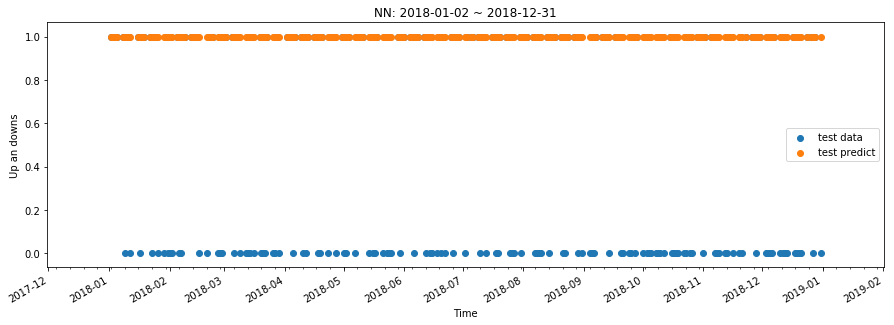

In [26]:
test_predict = model.predict_classes(test_X)

fig, ax = plt.subplots(figsize=(15, 5))

fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.set(title='NN: 2018-01-02 ~ 2018-12-31', xlabel='Time', ylabel='Up an downs')
ax.scatter(test_data['Date'], test_data['Up or Down'], label='test data')
ax.scatter(test_data['Date'], test_predict, label='test predict')
ax.legend()
plt.show()

預測結果全部集中在同一側

# Conclusion

* 若單純以測試資料的正確率來看，三者大同小異，NN: 51.98% > logistic: 50.79% > SVM: 44.05%，都不算好的分類器
* 由於特徵顯著性太低，且漲跌分布平均，較難以提升正確率
* 且分類只有漲跌兩種，無法得知確切的幅度，對於那種收盤價與前一天差距極小的案例就影響甚大
* 以訓練資料來看，整體的趨勢是持續上揚，所以訓練出來的模型也較容易頃向於漲，而測試資料的趨勢變動較大，也影響到模型的正確率
* 由於這次資料特徵較為單純，一些 normalization 和 encoding 就不需要做了
* 如果取相對短期的訓練資料，訓練上斜率的影響就不會像原本一樣大了